## Testing the methos from "Robust multimodal models have outlier features and encode more concepts"

arxiv link : https://arxiv.org/pdf/2310.13040.pdf

The aim is to test the metrics and the methods on a few models during journal club on 5th Aril, 2024

In [1]:
import sys
sys.path.append('/Users/bhavin/Documents/Projects/representationalAnalysis')

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from scipy.spatial.distance import pdist, squareform
from analysis import rsa,cka
from analysis.kurtosis_and_importance import calculate_kurtosis,calculate_importance
from tqdm import trange
%matplotlib inline

#### Average Kurtosis is defined as : 

$$ \overline{kurtosis} = \frac{1}{N} \sum_{n=1}^{N} \frac{1}{d_H} \sum_{i=1}^{d_H} \Big[ \frac{ h_{i}^{(n)} - \mu (h^{(n)})}{\sigma (h^{(n)})}\Big]^4 $$

#### Importance is defined as : 


$$Importance(i) = \frac{\sigma_i}{\sum_{j=1}^{rank(W)} \sigma_j} \cdot \sum_{n=1}^{N} \frac{ |\cos(v_i,h^{(n)}) | }{N} $$

With this metric, we can measure to what extent the presence of outlier features induces privileged directions in representation space. If such privileged directions exist, we expect some singular directions $v_i$ to have an $Importance(i)$ substantially higher than average, i.e. with $ Importance(i) >> d^{−1}_{H} \sum^{dH}_{j=1} Importance(j) $

In [2]:
def calculate_kurtosis(features : list) -> float:
    '''
    Args: 
        features: list of all the features (flattened with a final dimensionality d_h)
    '''

    d_h = features[0].shape

    kurtosis_sum = 0.
    for feat in features:
        mu_h = feat.mean()
        std = feat.std()
        val =((feat - mu_h)/std)**4
        assert val.shape == d_h
        val = val.mean()
        kurtosis_sum += val
    
    average_kurtosis = kurtosis_sum/len(features)
    return average_kurtosis


def calculate_importance(W : np.array,features : list) -> dict:
    '''
    Calculate importances as defined by https://arxiv.org/pdf/2310.13040.pdf
    Args: 
        W : weight matrix of shape (M,N)
        features : list of features over which the importance of projections is to be calculated
    Returns: 
        A dictionary with the svd decomposition and the importance values
    '''

    assert len(W.shape) == 2

    U,singular_vals,Vh = np.linalg.svd(W,full_matrices=False)

    # NOTES : 
    # W = SUMMATION_(over i) sigma_i . u_i @ v_i.T ...where sigma is the singular value
    # total = np.zeros(W.shape)
    # for i in range(12):
    #     ith_component = s[i-1] * U[:,i:(i+1)] @ Vh[i:(i+1)]
    #     print (ith_component.shape)
    #     total += ith_component
    #
    # print ('Difference after performing SVD: ',np.mean((W - total)**2))

    importances = []
    for i in trange(singular_vals.shape[0],desc='Calculation projections on the v_i'):
        v_i = Vh[i:(i+1)]
        cos_similarities = [np.abs(np.cos(v_i,feat)) for feat in features] #as per the definition by https://arxiv.org/pdf/2310.13040.pdf
        importance = (singular_vals[i-1] / singular_vals.sum()) * np.array(cos_similarities).mean()
        importances.append(importance)
    

    data = {
        'U' : U,
        'singular values' : singular_vals,
        'Vh' : Vh,
        'importances' : importances,
    }

    return data

In [3]:
albef_path = "/Users/bhavin/Documents/Projects/representationalAnalysis/assets/representations/dummy_albef_retrieval_imagenet_val_50_images.p"
clip_path = "/Users/bhavin/Documents/Projects/representationalAnalysis/assets/representations/dummy_vit_base_patch16_clip_384_imagenet_val_50_images.p"
vit_path = "/Users/bhavin/Documents/Projects/representationalAnalysis/assets/representations/dummy_vit_base_patch16_384_imagenet_val_50_images.p"


def get_albef_reps():
    with open(albef_path,'rb') as f:
        albef_reps = pickle.load(f)

    new_dict = {k:[] for k in albef_reps}
    print (f"{'ALBEF':=^60}")
    for k in albef_reps:
        print (f"{k:<20} --- {albef_reps[k][0].shape}")
        new_dict[k] = [x.flatten().detach().numpy() for x in albef_reps[k]]
    return new_dict

def get_clip_reps():
    with open(clip_path,'rb') as f:
        albef_reps = pickle.load(f)

    new_dict = {k:[] for k in albef_reps}
    print (f"{'CLIP':=^60}")
    for k in albef_reps:
        print (f"{k:<20} --- {albef_reps[k][0].shape}")
        new_dict[k] = [x.flatten().detach().numpy() for x in albef_reps[k]]
    return new_dict

def get_vit_reps():
    with open(vit_path,'rb') as f:
        albef_reps = pickle.load(f)

    new_dict = {k:[] for k in albef_reps}
    print (f"{'ViT':=^60}")
    for k in albef_reps:
        print (f"{k:<20} --- {albef_reps[k][0].shape}")
        new_dict[k] = [x.flatten().detach().numpy() for x in albef_reps[k]]
    return new_dict

albef_reps = get_albef_reps()
clip_reps = get_clip_reps()
vit_reps = get_vit_reps()

===========================ALBEF============================
encoder_layer_0      --- torch.Size([577, 768])
encoder_layer_1      --- torch.Size([577, 768])
encoder_layer_2      --- torch.Size([577, 768])
encoder_layer_3      --- torch.Size([577, 768])
encoder_layer_4      --- torch.Size([577, 768])
encoder_layer_5      --- torch.Size([577, 768])
encoder_layer_6      --- torch.Size([577, 768])
encoder_layer_7      --- torch.Size([577, 768])
encoder_layer_8      --- torch.Size([577, 768])
encoder_layer_9      --- torch.Size([577, 768])
encoder_layer_10     --- torch.Size([577, 768])
encoder_layer_11     --- torch.Size([577, 768])
image_embed          --- torch.Size([1, 577, 768])
image_feat           --- torch.Size([1, 256])
============================CLIP============================
encoder_layer_0      --- torch.Size([577, 768])
encoder_layer_1      --- torch.Size([577, 768])
encoder_layer_2      --- torch.Size([577, 768])
encoder_layer_3      --- torch.Size([577, 768])
encoder_layer

## Kurtosis

In [4]:
albef_kurtosis = [calculate_kurtosis(albef_reps[k]) for k in albef_reps]
clip_kurtosis = [calculate_kurtosis(clip_reps[k]) for k in clip_reps]
vit_kurtosis = [calculate_kurtosis(vit_reps[k]) for k in vit_reps]

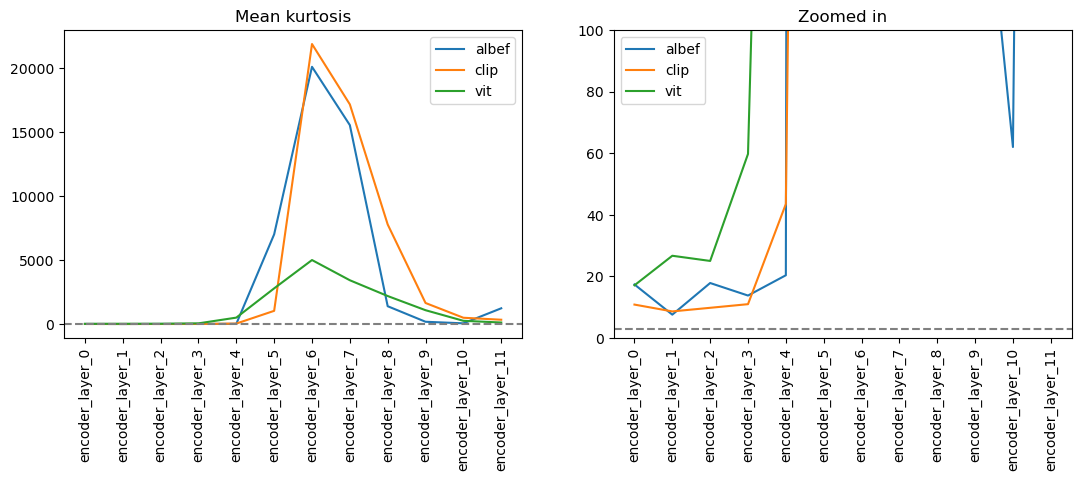

In [5]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.title('Mean kurtosis')
plt.plot(albef_kurtosis[:-2],label='albef')
plt.plot(clip_kurtosis[:-2],label='clip')
plt.plot(vit_kurtosis[:-2],label='vit')
plt.axhline(3,linestyle='dashed',color='gray')
plt.xticks(np.arange(12),list(albef_reps)[:-2],rotation=90)
plt.legend()

plt.subplot(122)
plt.title('Zoomed in')
plt.plot(albef_kurtosis[:-2],label='albef')
plt.plot(clip_kurtosis[:-2],label='clip')
plt.plot(vit_kurtosis[:-2],label='vit')
plt.axhline(3,linestyle='dashed',color='gray')
plt.xticks(np.arange(12),list(albef_reps)[:-2],rotation=90)
plt.ylim(0,100)
plt.legend()

## Importance

In [42]:
dummy_layer = torch.nn.Linear(256,1000,bias=False)
W = dummy_layer.weight.detach().numpy()

features = [np.expand_dims(x,0) for x in albef_reps['image_feat']]
# features = [np.random.randn(*x.shape) for x in features] #random features
data = calculate_importance(W,features)
print (*data.keys(),sep='\n')

Calculation projections on the v_i: 100%|███████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 13532.06it/s]

U
singular values
Vh
importances


Text(0.5, 1.0, 'Importances')

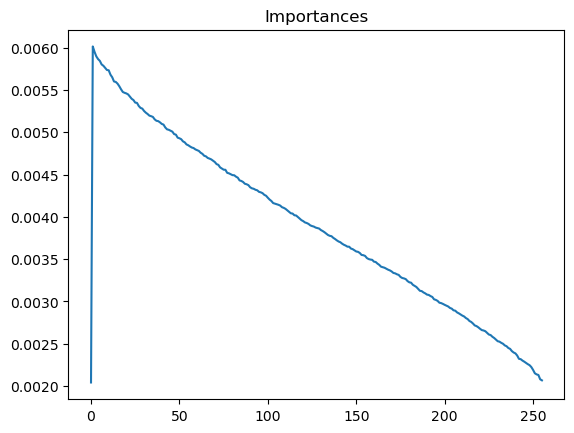

In [43]:
plt.plot(data['importances'])
plt.title("Importances")